In [317]:
import sys
sys.path.append('../../../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path

from utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
odor_list_color = [color1, color2, color3]
color_dict = {1: color1, 0: color2, 2: color3}
color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3}

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = 'Z:/scratch/vr-foraging/data/'
foraging_figures = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\results'

from scipy.optimize import curve_fit


# **One session exploration**

In [371]:
date = datetime.date.today()
date_string = "6/10/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()
mouse = '715865'

In [372]:
session_found = False

directory = os.path.join(base_path, mouse)
files = os.listdir(os.path.join(base_path, mouse))

sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)

# All this segment is to find the correct session without having the specific path
for file_name in sorted_files:
    
    if session_found == True:
        break
    
    print(file_name)
    # Find specific session sorted by date
    session_path = os.path.join(base_path, mouse, file_name)
    session = file_name[:8]
    session_path = Path(session_path)
    
    if datetime.date.fromtimestamp(os.path.getctime(session_path)) != date:
        continue
    else:
        print('correct date found')
        session_found = True

    # Recover data streams
    data = parse.load_session_data(session_path)
    
    # Parse data
    reward_sites, active_site, config = parse.parse_dataframe(data)
    reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
    encoder_data = parse.ContinuousData(data).encoder_data

    last_engaged_patch = reward_sites['active_patch'][reward_sites['skipped_count'] >= 10].min()
    if pd.isna(last_engaged_patch):
        last_engaged_patch = reward_sites['active_patch'].max()
    reward_sites = reward_sites.loc[reward_sites['active_patch'] <= last_engaged_patch]

20240610T084741
correct date found


In [373]:
# Summary of different relevants aspects -------------------------------------------------
collected_df = reward_sites['collected'].sum()

unrewarded_stops = reward_sites.loc[reward_sites.reward_delivered==0]['collected'].count()
rewarded_stops = reward_sites.loc[reward_sites.reward_delivered==1]['collected'].count()
water_collected = reward_sites.loc[(reward_sites['reward_delivered']==1)]['collected'].sum()
total_stops = reward_sites.loc[(reward_sites['has_choice']==True)]['reward_available'].count()

stopped_df = reward_sites.loc[(reward_sites['has_choice']==True)].groupby(['collected','odor_label'])[['reward_delivered']].sum().reset_index()

# Rewarded stops / total available rewarded stops
optimality = rewarded_stops / reward_sites[reward_sites.reward_available != 0]['reward_delivered'].count()

# Rewarded stops / Stops
efficiency = rewarded_stops / reward_sites.reward_delivered.sum()

print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
    'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')

if 'startPosition' in active_site.columns:
    stop_duration = np.round(active_site.startPosition.max()/100,2)
else:
    stop_duration = np.round(active_site.start_position.max()/100,2)
print('Total travelled m: ', np.round(active_site.start_position.max()/100,2))

for odor_label in reward_sites.odor_label.unique():
    values = reward_sites.loc[(reward_sites['odor_label']==odor_label)&(reward_sites['reward_delivered']==1)]['collected'].sum()
    print(f'{odor_label} {values} ul')

Total sites:  396  |  Total rewarded stops:  212 ( 65.63 %) |  Total unrewarded stops:  184 ( 56.97 %) |  Water consumed:  1060.0 ul
Total travelled m:  499.72
2-Heptanone 630.0 ul
Methyl Acetate 430.0 ul
Fenchone 0.0 ul


Recovering data streams individually to plot in a time period. 

### Segments of the session

Sequential data showing different elements of the behavior all together. 

In [374]:
dict_odor = {0: data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][0]['label'], 
             1: data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][1]['label'], 
             2: data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][2]['label']}

color_dict_label = {data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][0]['label']: color1, 
                    data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][1]['label']: color2, 
                    data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][2]['label']: color3},
color_dict_label = color_dict_label[0]

label_dict = {
    "InterSite": '#808080',
    dict_odor[2]: '#7570b3',
    dict_odor[1]: '#d95f02',
    dict_odor[0]: '#1b9e77',
    "InterPatch": '#b3b3b3'}

In [375]:
active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()[1]
stream_data = parse.ContinuousData(data)

In [376]:
def update_plot(x_start):
    zero_index = active_site.index[0]

    fig, axs = plt.subplots(1,1, figsize=(20,4))
    
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['odor_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = p
        axs.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs.scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs.scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs.scatter(stream_data.valve_output_pulse.index - zero_index,
            stream_data.valve_output_pulse.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs.scatter(stream_data.succesfull_wait.index - zero_index,
    #     succesfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs.set_yticklabels([])
    axs.set_xlabel("Time(s)")
    axs.set_ylim(bottom=-1, top = 3)
    axs.grid(False)
    plt.gca().yaxis.set_visible(False)

    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(stream_data.encoder_data.index - zero_index, stream_data.encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")
    axs.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    axs.set_xlabel("Time(s)")
    axs.grid(False)
    axs.set_ylim(bottom=-1, top = 4)
    axs.set_yticks([0,3])
    axs.yaxis.tick_right()
    axs.set_xlim([x_start, x_start + 80])

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 80

def on_right_button_clicked(button):
    x_start_widget.value += 80

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

# if save_name is not None:
#     plt.savefig(janelia_figures + f"\{save_name}_time.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)

Output()

In [309]:
summary = reward_sites.loc[reward_sites.visit_number !=0].groupby(['active_patch','odor_label']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()

In [316]:
summary.groupby('odor_label').reward_probability.mean()

Series([], Name: reward_probability, dtype: float64)

In [321]:
reward_sites

,label,start_position,length,active_patch,visit_number,has_choice,reward_delivered,stop_cue,succesful_wait,water_onset,...,collected,depleted,last_visit,last_site,skipped_count,cumulative_rewards,consecutive_rewards,cumulative_failures,consecutive_failures,after_choice_cumulative_rewards
Seconds,,,,,,,,,,,,,,,,,,,,,
6.049143e+06,RewardSite,181.732826,50.0,0.0,0.0,False,0.0,NaN,NaN,NaN,...,0.0,0.0,0,1,1.0,0.0,0.0,0.0,0.0,0.0
6.049156e+06,RewardSite,435.319168,50.0,1.0,0.0,False,0.0,NaN,NaN,NaN,...,0.0,0.0,0,1,2.0,0.0,0.0,0.0,0.0,0.0
6.049165e+06,RewardSite,605.470707,50.0,2.0,0.0,False,0.0,NaN,NaN,NaN,...,0.0,0.0,0,1,3.0,0.0,0.0,0.0,0.0,0.0
6.049183e+06,RewardSite,1008.822492,50.0,3.0,0.0,False,0.0,NaN,NaN,NaN,...,0.0,0.0,0,1,4.0,0.0,0.0,0.0,0.0,0.0
6.049198e+06,RewardSite,1368.192140,50.0,4.0,0.0,False,1.0,NaN,NaN,6.049198e+06,...,5.0,0.0,0,1,5.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6.052337e+06,RewardSite,42138.173722,50.0,51.0,3.0,False,0.0,NaN,NaN,NaN,...,0.0,1.0,0,1,0.0,0.0,0.0,3.0,3.0,0.0
6.052448e+06,RewardSite,42345.954197,50.0,52.0,0.0,True,0.0,6.052449e+06,6.052449e+06,NaN,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
6.052457e+06,RewardSite,42449.554054,50.0,52.0,1.0,True,1.0,6.052458e+06,6.052458e+06,6.052458e+06,...,5.0,0.0,0,0,0.0,0.0,0.0,1.0,1.0,1.0


In [257]:
def raster_plot(x_start, pdf):
    fig, axs = plt.subplots(1,1, figsize=(20,4))
    
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['odor_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = p
        axs.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs.scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs.scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs.scatter(stream_data.valve_output_pulse.index - zero_index,
            stream_data.valve_output_pulse.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs.scatter(stream_data.succesfull_wait.index - zero_index,
    #     succesfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs.set_yticklabels([])
    axs.set_xlabel("Time(s)")
    axs.set_ylim(bottom=-1, top = 3)
    axs.grid(False)
    plt.gca().yaxis.set_visible(False)

    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(stream_data.encoder_data.index - zero_index, stream_data.encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")
    
    axs.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
    axs.set_xlabel("Time(s)")
    axs.grid(False)
    axs.set_ylim(bottom=-1, top = 4)
    axs.set_yticks([0,3])
    axs.yaxis.tick_right()
    axs.set_xlim([x_start, x_start + 80])
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)    
    
pdf_filename = mouse + '_' + session + '_raster.pdf'

zero_index = active_site.index[0]

# Save each figure to a separate page in the PDF
with PdfPages(pdf_path+"\\"+pdf_filename) as pdf:
    for x_start in range(0, int(active_site.index[-1] - zero_index), 80):
        raster_plot(x_start, pdf)

### Segments of the session in patches

Same as above but plotting only one patch at a time

In [ ]:
def update_plot(x_start):
    zero_index = active_site.index[0]

    start = active_site.loc[active_site['active_patch']==x_start].index[0] - zero_index
    stop = active_site.loc[active_site['active_patch']==x_start+1].index[1] - zero_index
    
    fig, axs = plt.subplots(1,1, figsize=(20,4))
    plt.title('Patch: ' + str(x_start))
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['odor_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = p
        axs.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs.scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs.scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs.scatter(stream_data.valve_output_pulse.index - zero_index,
            stream_data.valve_output_pulse.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs.scatter(stream_data.succesfull_wait.index - zero_index,
    #     succesfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs.set_yticklabels([])
    axs.set_xlabel("Time(s)")
    axs.set_ylim(bottom=-1, top = 3)
    axs.grid(False)
    plt.gca().yaxis.set_visible(False)

    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(stream_data.encoder_data.index - zero_index, stream_data.encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")
    axs.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    axs.set_xlabel("Time(s)")
    axs.grid(False)
    axs.set_ylim(bottom=-1, top = 4)
    axs.set_yticks([0,3])
    axs.yaxis.tick_right()
    axs.set_xlim([start, stop])

# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 1

def on_right_button_clicked(button):
    x_start_widget.value += 1

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

### Segments of the session with sniff data

Explore data but having the sniff data on top (it takes longer to plot)

In [ ]:
def update_plot(x_start):
    zero_index = active_site.index[0]

    fig, axs = plt.subplots(2,1, figsize=(20,8), gridspec_kw={'height_ratios': [2, 2]}, sharex=True)

    # sites_test = sites.loc[(sites.index > (zero_index + x_start))&(sites.index < (zero_index + x_start + 50))]   
    _legend = {}
    for idx, site in enumerate(active_site.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "RewardSite":
            site_label = site[1]['odor_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        
        _legend[site_label] = p
        axs[0].add_patch(p)
        
        q = Rectangle(
            (active_site.index[idx] - zero_index, -2), active_site.index[idx+1] - active_site.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = q
        axs[1].add_patch(q)
        # axs[1].add_patch(p)
        
    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs[1].scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs[1].scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs[1].scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs[1].scatter(stream_data.successfull_wait.index - zero_index,
    #     stream_data.successfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs[1].set_yticklabels([])
    axs[1].set_xlabel("Time(s)")
    axs[1].set_ylim(bottom=-1, top = 3)
    axs[1].grid(False)

    ax2 = axs[1].twinx()
    _legend["Velocity"] = ax2.plot(encoder_data.index - zero_index, encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")
    
    ax3 = axs[0].twinx()
    _legend["Breathing"] = ax3.plot(stream_data.breathing.index - zero_index, stream_data.breathing.values, c="black", label="Breathing", alpha = 0.8)[0]
    # _legend["Breathing"] = ax3.plot(filtered_breathing.index - zero_index, filtered_breathing['data'].values, c="black", label="Breathing", alpha = 0.8)[0]

    ax3.grid(False)
    # ax3.set_ylim((1900, 2150))
    # ax3.set_ylim((-25, 50))
    ax3.set_ylabel("Breathing (V)")
    
    axs[0].legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.1), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    for i in [0,1]:
        axs[i].set_xlabel("Time(s)")
        axs[i].grid(False)
        axs[i].set_ylim(bottom=-1, top = 4)
        axs[i].set_yticks([0,3])
        axs[i].yaxis.tick_right()
        axs[i].set_xlim([x_start, x_start + 50])
        
    # plt.savefig(foraging_figures + f"\{x_start_widget.value}_time_detrended.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)
    
# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 50

def on_right_button_clicked(button):
    x_start_widget.value += 50

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

### **Detailed plots**
With the dataframe reward_sites you can explore different aspects of the behavior. You can for instance use it to align velocity traces and look at how they might be different for different odors. 

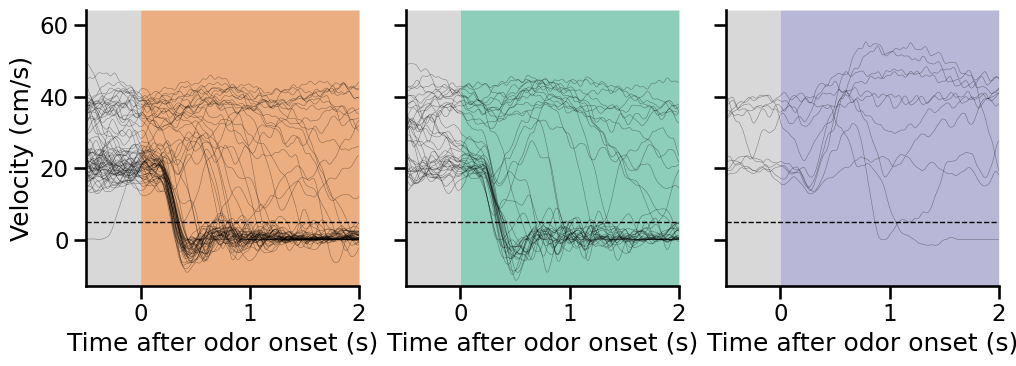

In [340]:
trial_summary = plotting.trial_collection(reward_sites[['has_choice', 'visit_number', 'odor_label', 'odor_onset', 'odor_sites']], encoder_data, mouse, session, window=(-1,3), aligned='odor_onset')
plotting.velocity_traces_odor_summary(trial_summary, max_range=max(trial_summary.speed.values), color_dict_label=color_dict_label, mean=False, save=False)

Look at a summary of the session plotting each patch and site and look at whether they were rewarded or not

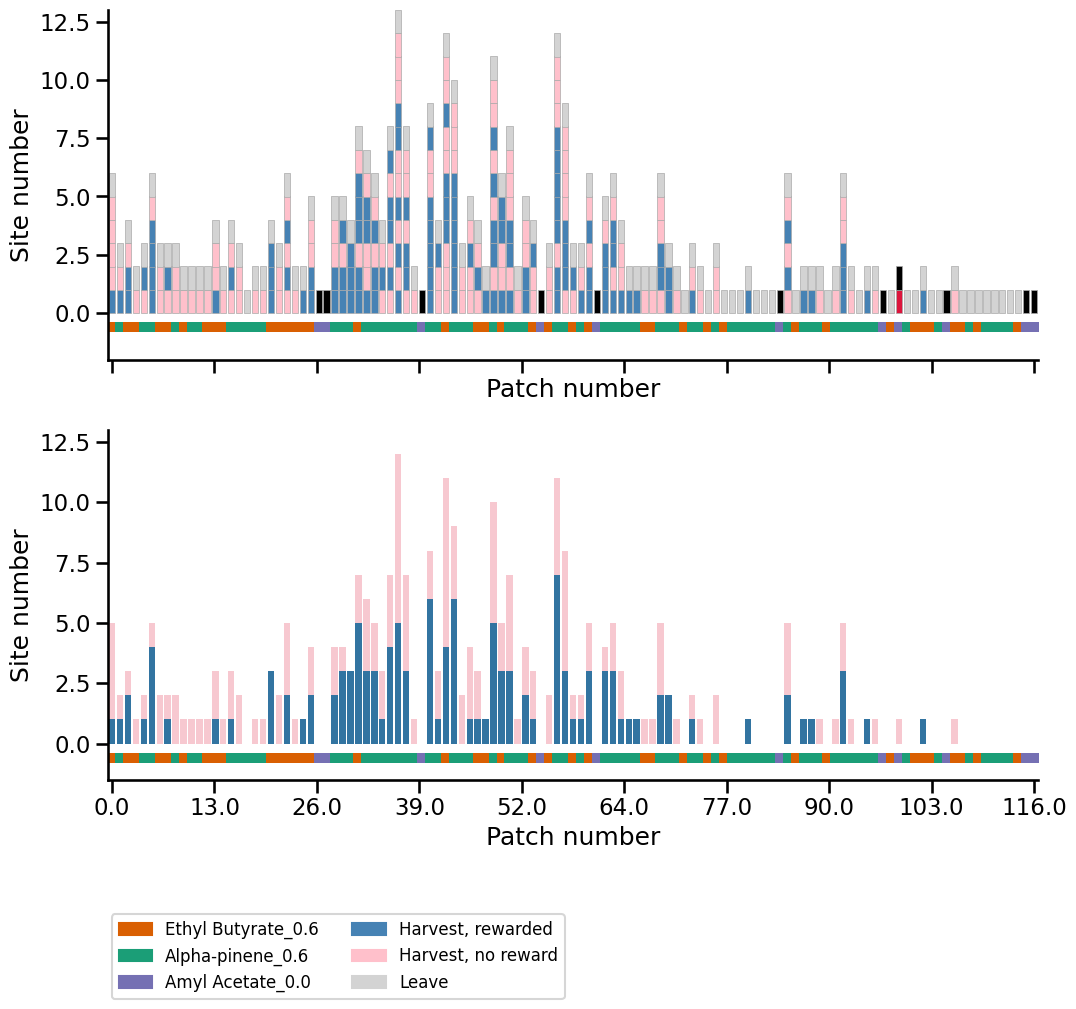

In [341]:
summary = reward_sites.groupby(['active_patch','odor_label']).agg({'reward_delivered':'sum','visit_number':'count'})

patch_number = len(reward_sites.active_patch.unique())
number_odors = len(reward_sites['odor_label'].unique())
list_odors = []
for odor in reward_sites.odor_label.unique():
    list_odors.append(reward_sites.loc[reward_sites.odor_label == odor].active_patch.nunique())
grid = (np.array(list_odors)/patch_number)*number_odors

fig, ax = plt.subplots(2,1, figsize=(12, 10), sharex=True)

for index, row in reward_sites.iterrows():
    if row['reward_delivered'] == 1 and row['has_choice'] == True:
        color='steelblue'
    elif row['reward_delivered'] == 0 and row['has_choice'] == True:
        color='pink'
        if row['reward_available'] == 0:
            color='crimson'
    else:
        if  row['reward_available'] == 0:
            color='black'
            hatch = '/'
        else:
            color='lightgrey'
        
    ax[0].bar(int(row['active_patch']), bottom=row['visit_number'], height=1, width=0.8, color=color, edgecolor='darkgrey', linewidth=0.5)
    ax[0].set_xlim(-1,max(reward_sites.active_patch)+1)
    ax[0].set_xlim(-1,50)
    ax[0].set_xlabel('Patch number')
    ax[0].set_ylabel('Site number')
    
    if row['odor_label'] == reward_sites['odor_label'].unique()[0]:
        patch_color=odor_list_color[0]
    elif row['odor_label'] == reward_sites['odor_label'].unique()[1]:
        patch_color=odor_list_color[1]
    else:
        patch_color=odor_list_color[2]
    
    # ax1.bar(int(row['active_patch']), bottom = -1, height=0.5, width = 1, color=patch_color, edgecolor='black', linewidth=0.5)
    ax[0].scatter(row['active_patch'], -0.6, color=patch_color, marker='s', s=60, edgecolor='black', linewidth=0.0)
    ax[1].scatter(row['active_patch'], -0.6, color=patch_color, marker='s', s=60, edgecolor='black', linewidth=0.0)

odors = []
for index, odor in enumerate(reward_sites['odor_label'].unique()):
    odors.append(mpatches.Patch(color=odor_list_color[index], label=(str(odor) + '_' + str(reward_sites.loc[reward_sites.odor_label == odor].reward_probability.max()))))

label_2 = mpatches.Patch(color='steelblue', label='Harvest, rewarded')
label_3 = mpatches.Patch(color='pink', label='Harvest, no reward')
label_4 = mpatches.Patch(color='lightgrey', label='Leave')

odors.extend([label_2, label_3,label_4])
plt.legend(handles=odors, loc='lower right', bbox_to_anchor=(0.5, -0.65), fontsize=12, ncol=2)
ax[0].set_ylim(-2,max(reward_sites.visit_number)+1)

summary = reward_sites.groupby(['active_patch','odor_label']).agg({'reward_delivered':'sum','has_choice':'sum'})
summary.reset_index(inplace=True)

sns.barplot(x='active_patch', y='has_choice',data=summary, color='pink', ax=ax[1], errorbar=None)
sns.barplot(x='active_patch', y='reward_delivered', data=summary, ax=ax[1], errorbar=None)

# Specifying the number of xticks
num_ticks = 10  # Change this to the desired number of ticks
xticks = np.linspace(summary.active_patch.min(), summary.active_patch.max(), num_ticks)

# Specifying the xticks
ax[1].set_xticks(xticks)
# ax[1].set_xlim(-1,125)
ax[1].set_ylim(-1.5,reward_sites.visit_number.max()+1)
ax[1].set_ylabel('Site number')
ax[1].set_xlabel('Patch number')
sns.despine()

# fig.savefig(foraging_figures+f'/raster_plot_example_{mouse}_{date}.svg', dpi=300, bbox_inches='tight')

Explore if animals experienced a decaying curve close to the theoretical one

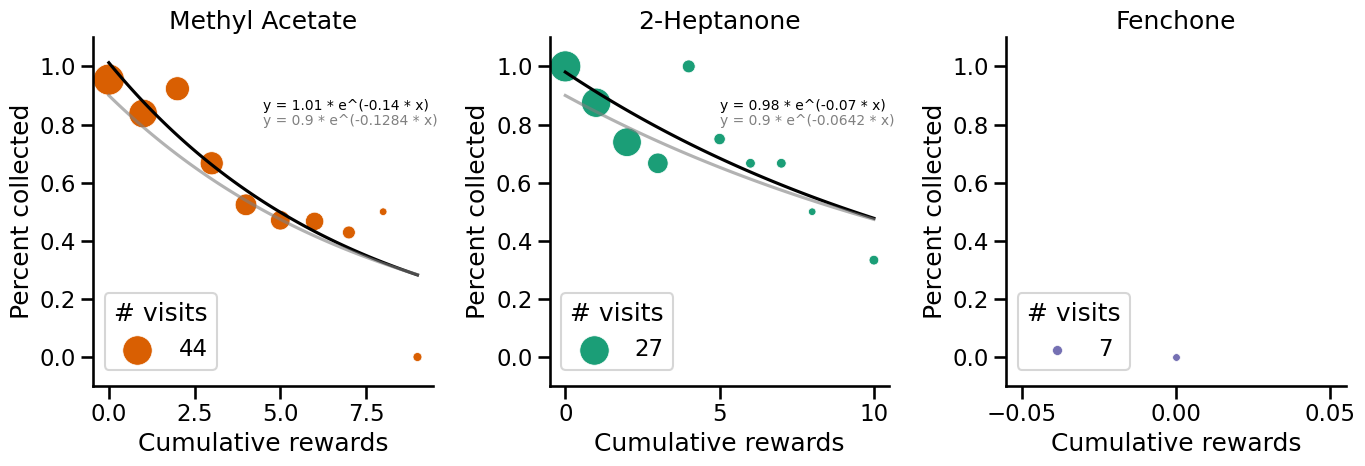

In [260]:
dict_odor = {}
for i in range(len(data['config'].streams.tasklogic_input.data['environment_statistics']['patches'])):
    odor_label = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i]['label']
    rate = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['c']
    offset = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['a']
    dict_odor[odor_label] = {'rate':rate, 'offset':offset, 'color': color_dict_label[odor_label]}

summary = reward_sites.loc[reward_sites.has_choice==True].groupby(['cumulative_rewards','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)

summary.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(14, 5))
i = 0
for odor in dict_odor.keys():
    odor_df = summary.loc[summary['odor_label'] == odor]
    odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]
    if odor_df.empty:
        continue
    
    sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
    
    # Plot exponential curve
    popt, pcov = curve_fit(processing.exponential_func, odor_df['cumulative_rewards'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
    
    # Plot curve for this odor in theroy
    rate = dict_odor[odor]['rate']
    offset = dict_odor[odor]['offset']
    if popt[1] < 0:
        x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
        ax[i].plot(x_values, processing.exponential_func(x_values, *popt), color='black', label='Exponential Fit')
        ax[i].plot(x_values, processing.exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
        ax[i].text(max(odor_df.cumulative_rewards)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
        ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

    ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_title(odor)
    ax[i].set_ylabel('Percent collected')
    ax[i].set_xlabel('Cumulative rewards')
    plt.tight_layout()
    sns.despine()
    i += 1

UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

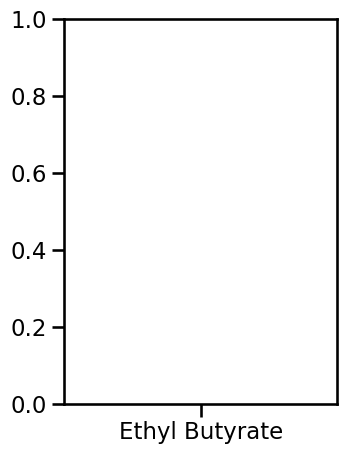

In [210]:
plotting.preward_estimates(reward_sites, color_dict_label = color_dict_label)